In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Embedding, Conv2D, MaxPooling2D,
                                     Flatten, Concatenate, Dense, Dropout, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [2]:
df_train = pd.read_csv('/content/df_train_clean.csv')
df_dev = pd.read_csv('/content/df_dev_clean.csv')
df_test = pd.read_csv('/content/df_test_clean.csv')

print(df_train.head())
print(df_dev.head())
print(df_test.head())

   Unnamed: 0    Emotion                                            content  \
0         188      Other              cho mình xin bài nhạc tên là gì với ạ   
1         166    Disgust  cho đáng đời con quỷ . về nhà lôi con nhà mày ...   
2        1345    Disgust  lo học đi . yêu đương lol gì hay lại thích học...   
3         316  Enjoyment    uớc gì sau này về già vẫn có thể như cụ này :))   
4        1225  Enjoyment  mỗi lần có video của con là cứ coi đi coi lại ...   

                                       content_clean  
0              cho mình xin bài nhạc tên là gì với ạ  
1  cho đáng đời con quỷ . về nhà lôi con nhà mày ...  
2  lo học đi . yêu đương lồn gì hay lại thích học...  
3     uớc gì sau này về già vẫn có thể như cụ này ☺️  
4  mỗi lần có video của con là cứ coi đi coi lại ...  
   Unnamed: 0    Emotion                                            content  \
0         941      Other  tính tao tao biết , chẳng có chuyện gì có thể ...   
1         142  Enjoyment           lạ

In [3]:
text_col = 'content_clean'
label_col = 'Emotion'

In [4]:
all_labels = pd.concat([df_train[label_col], df_dev[label_col], df_test[label_col]])
le = LabelEncoder()
le.fit(all_labels)
num_classes = len(le.classes_)

y_train = le.transform(df_train[label_col])
y_dev = le.transform(df_dev[label_col])
y_test = le.transform(df_test[label_col])

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_dev_cat = tf.keras.utils.to_categorical(y_dev, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [5]:
all_text = pd.concat([df_train[text_col], df_dev[text_col], df_test[text_col]])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
vocab_size = len(tokenizer.word_index) + 1
max_seq_len = 100

def encode_text(df):
    return pad_sequences(tokenizer.texts_to_sequences(df[text_col]), maxlen=max_seq_len)

X_train = encode_text(df_train)
X_dev = encode_text(df_dev)
X_test = encode_text(df_test)

In [6]:
emolex = pd.read_excel('/content/VnEmoLex.xlsx')
print(emolex.head())
print(emolex.columns)

  Unnamed: 0            Vietnamese  Positive  Negative  Anger\n/ tức giận  \
0  celebrity             Danh nhân         1         0                    0   
1  celebrity            danh tiếng         1         0                    0   
2      opera  nghệ thuật nhạc kịch         0         0                    0   
3  celebrity          sự nổi tiếng         1         1                    0   
4    endless               bất tận         0         0                    0   

   Anticipation\n/ Hi vọng  Disgust\n/ chán ghét  Fear\n/ sợ hãi  \
0                        0                   0.0                 0   
1                        1                   0.0                 0   
2                        0                   0.0                 0   
3                        1                   0.0                 0   
4                        0                   0.0                 1   

   Joy\n/ thích thú  Sadness\n/ buồn bã  Surprise\n/ ngạc nhiên  \
0                   1           

In [7]:
# Đúng tên cột như trong file bạn
main_emotions = [
    'Anger\n/ tức giận',
    'Disgust\n/ chán ghét',
    'Fear\n/ sợ hãi',
    'Joy\n/ thích thú',
    'Sadness\n/ buồn bã',
    'Surprise\n/ ngạc nhiên'
]
word_col = 'Vietnamese'

In [8]:
def is_float_column(col):
    try:
        pd.to_numeric(emolex[col].dropna().iloc[0])
        return True
    except:
        return False
all_emotion_columns = [col for col in main_emotions if is_float_column(col)]

emolex_dict = {}
for i, row in emolex.iterrows():
    word = str(row[word_col]).strip().lower()
    vector = []
    for col in all_emotion_columns:
        try:
            value = float(row[col])
        except:
            value = 0.0
        vector.append(value)
    emolex_dict[word] = np.array(vector, dtype=float)

In [9]:
emoji2word_df = pd.read_excel('/content/emoji2word.xlsx')
print("Cột trong emoji2word_df:", emoji2word_df.columns)

Cột trong emoji2word_df: Index(['word', 'emoji', 'word_vn_upcase', 'word_vn', 'emoji_no_punc'], dtype='object')


In [10]:
emoji_col = 'emoji'
emotion_word_col = 'word_vn'

emoji2word = {str(row[emoji_col]).strip(): str(row[emotion_word_col]).strip().lower()
              for _, row in emoji2word_df.iterrows()}

def extract_emojis(text):
    # Đơn giản: lấy hết các emoji unicode phổ biến
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002700-\U000027BF"
        u"\U0001F900-\U0001F9FF"
        "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)


In [11]:
def vn_emolex_features_text_and_emoji(text):
    # 1. Đặc trưng từ văn bản
    words = re.findall(r'\w+', str(text).lower())
    emotion_vec = np.zeros(len(main_emotions))
    for w in words:
        if w in emolex_dict:
            emotion_vec += emolex_dict[w]

    # 2. Đặc trưng từ emoji (emoji → từ cảm xúc → tra VnEmoLex → cộng vào vector)
    emojis = extract_emojis(text)
    for emoji in emojis:
        if emoji in emoji2word:
            emo_word = emoji2word[emoji]
            if emo_word in emolex_dict:
                emotion_vec += emolex_dict[emo_word]

    return emotion_vec

def batch_vn_emolex_features_all(series):
    return np.vstack([vn_emolex_features_text_and_emoji(s) for s in series])

X_train_emolex = batch_vn_emolex_features_all(df_train[text_col])
X_dev_emolex   = batch_vn_emolex_features_all(df_dev[text_col])
X_test_emolex  = batch_vn_emolex_features_all(df_test[text_col])


In [12]:
df_train

,Unnamed: 0,Emotion,content,content_clean
0,188,Other,cho mình xin bài nhạc tên là gì với ạ,cho mình xin bài nhạc tên là gì với ạ
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...,lo học đi . yêu đương lồn gì hay lại thích học...
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :)),uớc gì sau này về già vẫn có thể như cụ này ☺️
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...,...,...
5543,1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544,825,Other,nhìn mặt héo queo luôn,nhìn mặt héo queo luôn
5545,165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546,363,Enjoyment,thích thân hình boss rồi nhan 😌,thích thân hình boss rồi nhan 😌


In [13]:
def emoji_count(text):
    return len(extract_emojis(text))

def batch_emoji_count(series):
    return np.array([emoji_count(s) for s in series]).reshape(-1, 1)

X_train_emoji_count = batch_emoji_count(df_train[text_col])
X_dev_emoji_count   = batch_emoji_count(df_dev[text_col])
X_test_emoji_count  = batch_emoji_count(df_test[text_col])

# Chuẩn hóa (nên chia cho max của tập train, nếu cần)
max_count = X_train_emoji_count.max() if X_train_emoji_count.max() > 0 else 1
X_train_emoji_count = X_train_emoji_count / max_count
X_dev_emoji_count   = X_dev_emoji_count / max_count
X_test_emoji_count  = X_test_emoji_count / max_count

In [14]:
import tensorflow as tf

def categorical_focal_loss(alpha=0.3, gamma=0.2):
    def loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1-1e-9)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        fl = weights * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return loss

In [15]:
def build_textcnn_emolex_emoji(vocab_size, max_seq_len, num_classes, emolex_dim, embed_dim=100, dropout_rate=0.2):
    input_seq = Input(shape=(max_seq_len,))
    embed = Embedding(vocab_size, embed_dim, input_length=max_seq_len)(input_seq)
    reshape = Reshape((max_seq_len, embed_dim, 1))(embed)
    filter_sizes = [1, 2, 3, 5]
    convs = []
    for size in filter_sizes:
        conv = Conv2D(32, kernel_size=(size, embed_dim), activation='relu')(reshape)
        pool = MaxPooling2D(pool_size=(max_seq_len - size + 1, 1))(conv)
        convs.append(pool)
    merged = Concatenate(axis=1)(convs)
    flatten = Flatten()(merged)
    dropout1 = Dropout(dropout_rate)(flatten)

    input_emolex = Input(shape=(emolex_dim,))
    input_emoji_count = Input(shape=(1,))
    merged_all = Concatenate()([dropout1, input_emolex, input_emoji_count])
    dropout2 = Dropout(dropout_rate)(merged_all)
    out = Dense(num_classes, activation='softmax')(dropout2)

    model = Model(inputs=[input_seq, input_emolex, input_emoji_count], outputs=out)
    return model

emolex_dim = len(main_emotions)
model = build_textcnn_emolex_emoji(vocab_size, max_seq_len, num_classes, emolex_dim)
model.compile(optimizer='adam', loss=categorical_focal_loss(alpha=0.3, gamma=0.25), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │    466,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 100, 100,  │          0 │ embedding[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 1,    │      3,232 │ reshape[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 99, 1, 32) │      6,432 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 98, 1, 32) │      9,632 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 1, 32) │     16,032 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 1, 32)  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 1, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 1, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 1, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 1, 32)  │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │                   │            │ max_pooling2d_1[… │
│                     │                   │            │ max_pooling2d_2[… │
│                     │                   │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 135)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 502,780 (1.92 MB)

 Trainable params: 502,780 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    [X_train, X_train_emolex, X_train_emoji_count], y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=([X_dev, X_dev_emolex, X_dev_emoji_count], y_dev_cat)
)

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.2824 - loss: 0.5193 - val_accuracy: 0.4767 - val_loss: 0.4225
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.5216 - loss: 0.3833 - val_accuracy: 0.5277 - val_loss: 0.3489
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.6338 - loss: 0.2928 - val_accuracy: 0.5408 - val_loss: 0.3405
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.7191 - loss: 0.2252 - val_accuracy: 0.5583 - val_loss: 0.3436
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.7860 - loss: 0.1728 - val_accuracy: 0.5700 - val_loss: 0.3508
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.8310 - loss: 0.1351 - val_accuracy: 0.5496 - val_loss: 0.3872
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.8736 - loss: 0.1036 - val_accuracy: 0.5423 - val_loss: 0.4078
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9117 - loss: 0.0794 -

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

       Anger     0.5000    0.4000    0.4444        40
     Disgust     0.5000    0.5833    0.5385       132
   Enjoyment     0.6546    0.6580    0.6563       193
        Fear     0.7250    0.6304    0.6744        46
       Other     0.4179    0.4341    0.4259       129
     Sadness     0.6545    0.6207    0.6372       116
    Surprise     0.4828    0.3784    0.4242        37

    accuracy                         0.5642       693
   macro avg     0.5621    0.5293    0.5430       693
weighted avg     0.5677    0.5642    0.5643       693



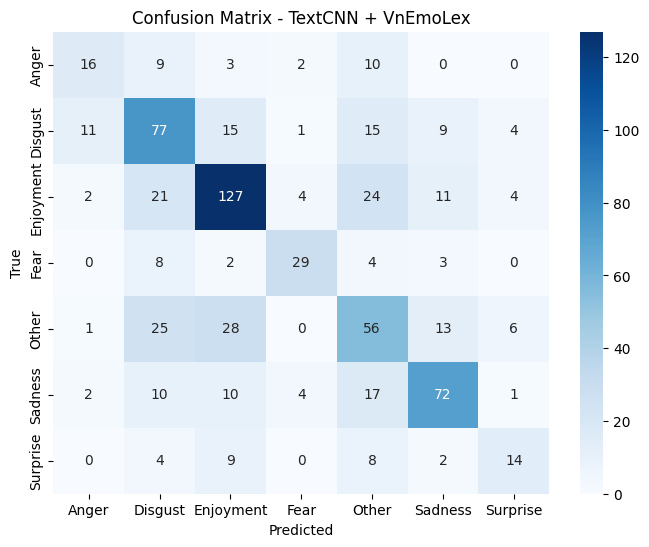

In [17]:
y_pred_probs = model.predict([X_test, X_test_emolex, X_test_emoji_count])
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix - TextCNN + VnEmoLex')
plt.show()

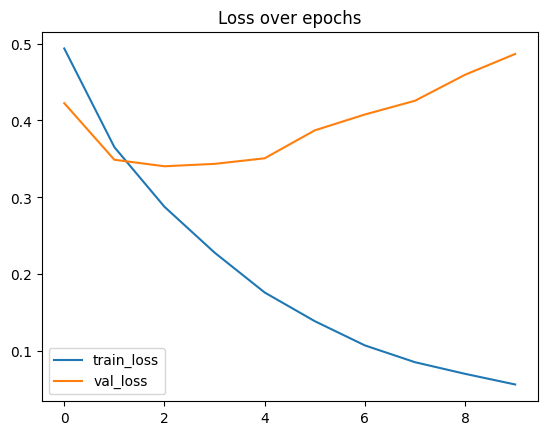

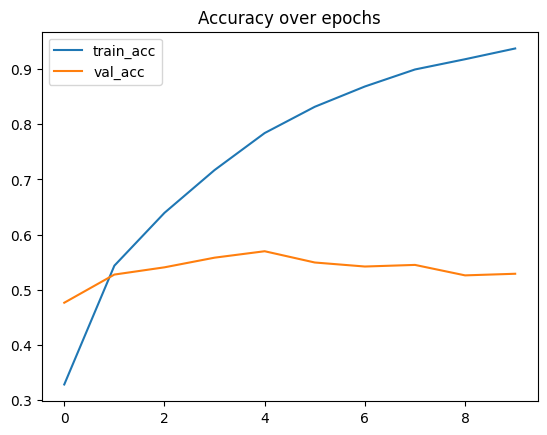

In [18]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss over epochs"); plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy over epochs"); plt.show()
